In this notebook we will explore the Medicare Part D prescribing data that was released through the CMS data portal at https://data.cms.gov/resource/4uvc-gbfz. The goal is to demonstrate how this data can be used to find prescribers who prescribe in a similar way. For a psychiatrist in Washington, D.C. we will determine which prescribers prescribe most closely by computing a distance matrix based on the total claims. More information about the data can be found at [Prescriber_Methods.pdf](https://data.cms.gov/api/views/4uvc-gbfz/files/9hYW-2MBrXAbhKuRXBE0AMbG7pRA5Q0MQCsDIJzlkTI?download=true&filename=Prescriber_Methods.pdf).

In [75]:
import pandas as pd

In [76]:
md_base_url = "https://data.cms.gov/resource/4uvc-gbfz" # URL For The Data

The data set contains 23,650,520 rows. We are not going to pull the entire data set down but a subset of the data.  To determine which state to pull down we use the Socrata SODA API to do the computation server side.

In [77]:
count_url = md_base_url + "?" + "$select=count(*)"
print(count_url)
pd.read_json(count_url)

https://data.cms.gov/resource/4uvc-gbfz?$select=count(*)


,count
0,23650520


In [78]:
count_by_state_url = md_base_url + "?" + "$select=nppes_provider_state,count(nppes_provider_state)&$group=nppes_provider_state"
print(count_by_state_url)
by_state_df = pd.read_json(count_by_state_url)
by_state_df[by_state_df.count_nppes_provider_state < 50000]

https://data.cms.gov/resource/4uvc-gbfz?$select=nppes_provider_state,count(nppes_provider_state)&$group=nppes_provider_state


,count_nppes_provider_state,nppes_provider_state
0,49,AS
1,240,AE
2,25,XX
3,30,AA
4,95,AP
5,348,MP
6,2739,VI
7,1073,ZZ
8,1816,GU
10,33668,WY


Socrata SODA version 2.0 of the API has a limit of 50,000 rows. It is possible to implement a strategy using the `$limit` and `$offset` operators in their API to extract larger datasets. We will focus on extracting data for prescribers that list their location in the District of Columbia. Rather than using the `pd.read_json()` using the `requests` library will be demonstrated. This will let us see the header of the HTTP response of the request.

In [79]:
import requests

In [57]:
r = requests.get(md_base_url, params={'$where': "nppes_provider_state='DC'", "$limit": 50000})

In [7]:
r.headers

{'Content-Encoding': 'gzip', 'Transfer-Encoding': 'chunked', 'X-SODA2-Warning': 'X-SODA2-Fields, X-SODA2-Types, and X-SODA2-Legacy-Types are deprecated', 'Age': '14', 'X-Socrata-RequestId': '8gn46axwl8aq99d93g1m1iwab', 'Server': 'nginx', 'X-SODA2-Legacy-Types': 'true', 'Last-Modified': 'Tue, 15 Sep 2015 10:59:54 PDT', 'Connection': 'keep-alive', 'Date': 'Fri, 20 May 2016 16:11:17 GMT', 'X-SODA2-Types': '["text","number","number","text","number","text","number","text","text","text","number","text","text","number","text","text","number","text","number"]', 'Access-Control-Allow-Origin': '*', 'Content-Type': 'application/json; charset=utf-8', 'X-Socrata-Region': 'production', 'X-SODA2-Fields': '["ge65_redact_flag","total_drug_cost","total_claim_count","bene_count_ge65_redact_flag","total_claim_count_ge65","npi","bene_count_ge65","nppes_provider_first_name","nppes_provider_state","nppes_provider_city","total_day_supply_ge65","specialty_desc","nppes_provider_last_org_name","total_drug_cost_g

In [8]:
prescriber_df = pd.read_json(r.content)

In [9]:
# Uncomment if you are unable to install the requests library
# prescriber_df = pd.read_json(prescriber_url)

In [10]:
prescriber_df.head(10)

,bene_count,bene_count_ge65,bene_count_ge65_redact_flag,description_flag,drug_name,ge65_redact_flag,generic_name,npi,nppes_provider_city,nppes_provider_first_name,nppes_provider_last_org_name,nppes_provider_state,specialty_desc,total_claim_count,total_claim_count_ge65,total_day_supply,total_day_supply_ge65,total_drug_cost,total_drug_cost_ge65
0,11.0,NaN,#,S,SANTYL,#,COLLAGENASE CLOSTRIDIUM HIST.,1689740086,WASHINGTON,LAILA,ALAMGIR,DC,Internal Medicine,25,NaN,152,NaN,4858.62,NaN
1,23.0,NaN,#,S,CLOPIDOGREL,NaN,CLOPIDOGREL BISULFATE,1811931140,WASHINGTON,MELVIN,GERALD,DC,Family Practice,134,111.0,3658,3091.0,5678.62,4991.20
2,NaN,0.0,NaN,S,MUPIROCIN,NaN,MUPIROCIN,1205152790,WASHINGTON,MELISSA,MUSZYNSKI,DC,Dermatology,15,0.0,360,0.0,499.46,0.00
3,NaN,0.0,NaN,S,JINTELI,NaN,NORETHIND AC/ETHINYL ESTRADIOL,1184939050,WASHINGTON,KRISTIE,QUARLES,DC,Nurse Practitioner,12,0.0,336,0.0,611.52,0.00
4,NaN,NaN,*,S,IRBESARTAN,NaN,IRBESARTAN,1518989821,WASHINGTON,ALEXANDER,CHESTER,DC,Internal Medicine,25,25.0,1530,1530.0,2115.60,2115.60
5,14.0,NaN,*,S,LANTUS,NaN,"INSULIN GLARGINE,HUM.REC.ANLOG",1346444791,WASHINGTON,ANDREW,ROBIE,DC,Family Practice,78,40.0,2246,1140.0,17008.75,8416.64
6,NaN,NaN,#,S,INSULIN SYRINGE,#,"SYRINGE & NEEDLE,INSULIN,1 ML",1225154651,WASHINGTON,AMY,PATTEN,DC,Nurse Practitioner,26,NaN,700,NaN,576.84,NaN
7,NaN,NaN,*,S,CIMETIDINE,NaN,CIMETIDINE,1033202601,WASHINGTON,NIKKI,HARRIS,DC,Family Practice,12,12.0,360,360.0,63.12,63.12
8,NaN,NaN,*,S,SPIRONOLACTONE,NaN,SPIRONOLACTONE,1538186176,WASHINGTON,THERESA,STONE,DC,Internal Medicine,11,11.0,720,720.0,172.07,172.07
9,23.0,0.0,NaN,S,TRUVADA,NaN,EMTRICITABINE/TENOFOVIR,1205877131,WASHINGTON,RAVI,AJMERA,DC,Internal Medicine,114,0.0,3420,0.0,137971.22,0.00


In [11]:
prescriber_df = prescriber_df.sort_values(by=["specialty_desc","npi","drug_name"])

A prescriber is identified by the NPI (National Provider Identifier). The NPI is a 10-digit number. We will use the Bloom API as an example of what information is linked to the NPI for a prescriber. This NPI associated data is self-reported by the provider. When a provider writes a prescription and the prescription is filled by a patient the NPI and the drug prescribed is recorded in the Medicare claims database. This data was aggregated over calendar year 2013 to form the underlying database.  This allows us to connect what drugs the prescriber prescribed to Medicare members. A prescriber may prescribe to other patients not in Medicare. This data is not in this data set. To protect the privacy of individuals only drugs with more than 11 claims during the year are included in this data set.

In [12]:
len("1487818670")

10

In [13]:
r = requests.get("http://www.bloomapi.com/api/search", 
                 params={"limit": 10,"offset": 0, "key1": "npi", "op1": "eq", "value1": 1487818670})
r.json()

{u'meta': {u'messages': [u"Warning: Use of the dataset, 'usgov.hhs.npi', without an API key is for development-use only. Use of this API without a key is rate-limited. For hosted, production access, please email 'support@bloomapi.com' for an API key."],
  u'rowCount': u'1'},
 u'result': [{u'business_address': {u'address_line': u'1221 TAYLOR ST NW',
    u'city': u'WASHINGTON',
    u'country_code': u'US',
    u'fax': u'2022070752',
    u'phone': u'2024649200',
    u'state': u'DC',
    u'zip': u'200115617'},
   u'credential': u'M.D.',
   u'enumeration_date': u'2008-07-16T00:00:00.000Z',
   u'first_name': u'NAVIN',
   u'gender': u'male',
   u'last_name': u'REDDY',
   u'last_update_date': u'2014-10-27T00:00:00.000Z',
   u'name_prefix': u'DR.',
   u'npi': u'1487818670',
   u'other_identifiers': [{u'identifier': u'057062300',
     u'state': u'DC',
     u'type': u'medicaid'}],
   u'practice_address': {u'address_details_line': u'OUTPATIENT PSYCHIATRIC',
    u'address_line': u'1221 TAYLOR ST NW'

In [14]:
# prescriber_df.to_csv("./data/medicare_dc_prescriber_raw_2013.csv")
# Uncomment last line if there are API Connection Problems
# prescriber_df = pd.read_csv("./data/medicare_dc_prescriber_raw_2013.csv")

In [15]:
import numpy as np

In [16]:
npi_drug_cross_df = pd.crosstab(prescriber_df["npi"], prescriber_df["drug_name"], values=prescriber_df["total_claim_count"], 
                                  aggfunc=np.sum)

If you have worked with Microsoft Excel you might be familiar with the concept of a pivot table. We want to create a dataframe where each row is a prescriber identified by their NPI and the columns of the table are the names of the drugs.

In [17]:
npi_drug_cross_df.head(5)

drug_name,ABACAVIR,ABILIFY,ABILIFY DISCMELT,ACARBOSE,ACCUPRIL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACIPHEX,ACTONEL,ACTOS,...,ZIPRASIDONE HCL,ZOCOR,ZOLOFT,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZOSTAVAX,ZYMAXID,ZYPREXA,ZYTIGA
npi,,,,,,,,,,,,,,,,,,,,,
1003005661,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
1003012063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003042474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003107541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003112434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To replace the NaN (not a number) from the cells with zero the `fillna()` method is used.

In [18]:
npi_drug_cross_df = npi_drug_cross_df.fillna(0)

Now it is simple to find the total number of claims for the drug Abilify.

In [19]:
npi_drug_cross_df["ABILIFY"].sum()

5167.0

To count the number of drugs we will add a new field called `drug_count` to the dataframe. Then we will use the `groupby()` and `agg()` methods to create a new dataframe. 

In [20]:
prescriber_df["drug_count"] = 1

In [21]:
prescriber_specialty_df = prescriber_df.groupby(["npi","specialty_desc"]).agg({"total_claim_count": np.sum,  "drug_count": np.sum})

To merge the tables we need to flatten the indices.

In [22]:
prescriber_specialty_df.reset_index(level=["npi","specialty_desc"], inplace=True)

In [23]:
prescriber_specialty_df.head(10)

,npi,specialty_desc,total_claim_count,drug_count
0,1003005661,General Practice,1253,35
1,1003012063,Internal Medicine,310,14
2,1003042474,Emergency Medicine,73,4
3,1003107541,Student in an Organized Health Care Education/...,70,4
4,1003112434,Student in an Organized Health Care Education/...,14,1
5,1003125253,Psychiatry & Neurology,61,3
6,1003128810,Internal Medicine,11,1
7,1003137480,Ophthalmology,11,1
8,1003172446,Student in an Organized Health Care Education/...,96,6
9,1003179474,Student in an Organized Health Care Education/...,30,2


In [24]:
prescriber_specialty_drugs_df = pd.merge(prescriber_specialty_df, npi_drug_cross_df.reset_index(level=["npi"]), on="npi")

In [25]:
prescriber_specialty_drugs_df.head(5)

,npi,specialty_desc,total_claim_count,drug_count,ABACAVIR,ABILIFY,ABILIFY DISCMELT,ACARBOSE,ACCUPRIL,ACETAMINOPHEN-CODEINE,...,ZIPRASIDONE HCL,ZOCOR,ZOLOFT,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZOSTAVAX,ZYMAXID,ZYPREXA,ZYTIGA
0,1003005661,General Practice,1253,35,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003012063,Internal Medicine,310,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003042474,Emergency Medicine,73,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003107541,Student in an Organized Health Care Education/...,70,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003112434,Student in an Organized Health Care Education/...,14,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we will show that different medical specialties prescribe different numbers of drugs. We expect that internal medicine which see a large number of different patients will prescribe the most number of drugs compared to a specialized field such as psychiatry.

In [58]:
import seaborn as sb

In [27]:
%matplotlib inline

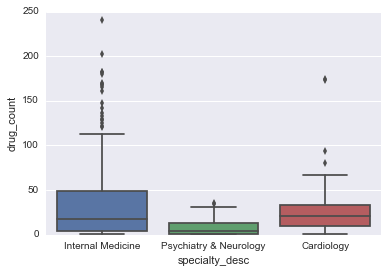

In [28]:
sb.boxplot(x="specialty_desc", y="drug_count", 
           data=prescriber_specialty_drugs_df[(prescriber_specialty_drugs_df["specialty_desc"] == "Cardiology") |
           (prescriber_specialty_drugs_df["specialty_desc"] == "Internal Medicine") |
           (prescriber_specialty_drugs_df["specialty_desc"] == "Psychiatry & Neurology")]
          )

Next we will build the dataframes and corresponding matrices to compute the euclidean distance between two Medicare prescribers in DC. Rather than creating a crosstab by `"drug_name"` we will use the `"generic_name"`. The branded drug Abilify has the generic name of ARIPiprazole. A great tool for understanding the relationship between active ingredients, generic name and branded product is [RxNav](https://rxnav.nlm.nih.gov/).

In [29]:
npi_generic_cross_df = pd.crosstab(prescriber_df["npi"], prescriber_df["generic_name"], values=prescriber_df["total_claim_count"], 
                                  aggfunc=np.sum)

In [30]:
npi_generic_cross_df = npi_generic_cross_df.fillna(0)

In [31]:
npi_generic_cross_df.head(5)

generic_name,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABATACEPT,ABIRATERONE ACETATE,ACARBOSE,ACETAMINOPHEN WITH CODEINE,ACETAZOLAMIDE,ACITRETIN,...,VILAZODONE HYDROCHLORIDE,WARFARIN SODIUM,ZAFIRLUKAST,ZALEPLON,ZANAMIVIR,ZIDOVUDINE,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
npi,,,,,,,,,,,,,,,,,,,,,
1003005661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0
1003012063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003042474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003107541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003112434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
npi_generic_cross_df.columns

Index([u'0.9 % SODIUM CHLORIDE', u'ABACAVIR SULFATE',
       u'ABACAVIR SULFATE/LAMIVUDINE', u'ABACAVIR/LAMIVUDINE/ZIDOVUDINE',
       u'ABATACEPT', u'ABIRATERONE ACETATE', u'ACARBOSE',
       u'ACETAMINOPHEN WITH CODEINE', u'ACETAZOLAMIDE', u'ACITRETIN',
       ...
       u'VILAZODONE HYDROCHLORIDE', u'WARFARIN SODIUM', u'ZAFIRLUKAST',
       u'ZALEPLON', u'ZANAMIVIR', u'ZIDOVUDINE', u'ZIPRASIDONE HCL',
       u'ZOLPIDEM TARTRATE', u'ZONISAMIDE', u'ZOSTER VACCINE LIVE/PF'],
      dtype='object', name=u'generic_name', length=746)

In [33]:
prescriber_specialty_generic_df = pd.merge(prescriber_specialty_df, npi_generic_cross_df.reset_index(level=["npi"]), on="npi")

In [34]:
prescriber_specialty_generic_df.head(5)

,npi,specialty_desc,total_claim_count,drug_count,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABATACEPT,ABIRATERONE ACETATE,...,VILAZODONE HYDROCHLORIDE,WARFARIN SODIUM,ZAFIRLUKAST,ZALEPLON,ZANAMIVIR,ZIDOVUDINE,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
0,1003005661,General Practice,1253,35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0
1,1003012063,Internal Medicine,310,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003042474,Emergency Medicine,73,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003107541,Student in an Organized Health Care Education/...,70,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003112434,Student in an Organized Health Care Education/...,14,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
prescriber_specialty_generic_df = prescriber_specialty_generic_df.sort_values(by=["specialty_desc", "npi"])

We will shift from using the Pandas dataframe object to the `numpy.array`. We need to slice off the columns that are not related to the number of filled prescriptions and convert this to a matrix. The `iloc()` method slices a dataframe by the column and the method `as_matrix()` converts the dataframe into a numpy array.

In [36]:
pf_matrix = prescriber_specialty_generic_df.iloc[: , 4: ].as_matrix()

In [37]:
pf_matrix.shape

(2519, 746)

We add an arrays for the identifiers an the generic name of the drugs.

In [38]:
identifiers_matrix = prescriber_specialty_df.iloc[:,0:2].as_matrix()

In [39]:
generic_array = prescriber_specialty_generic_df.columns[4:]

In order to compute the distance between a vector representing the drugs that a prescriber prescribes we need to import the `scipy.spatial` library.

In [40]:
import scipy.spatial

We normalize the claim count of prescriptions by the total number of claims for the prescriber. Each entry now represent the percentage of total claims that are associated with the prescriber.

In [41]:
normalized_pf_matrix = pf_matrix / np.reshape(np.sum(pf_matrix,1), (pf_matrix.shape[0],1))

In [42]:
normalized_pf_matrix.shape

(2519, 746)

We will use the euclidean distance to compute the distance between two prescribers. The results of the `pdist()` function need to be placed into square form. 

In [43]:
prescriber_dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(normalized_pf_matrix, "euclidean"))

In [44]:
prescriber_dist.shape

(2519, 2519)

As we have sorted the prescribers by their specialty then we expect to see some spatial patterns in the distance matrix. A matrix can be visualized using the `matplotlib` library.

In [45]:
import matplotlib.pyplot as plt

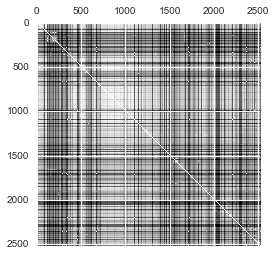

In [46]:
plt.matshow(prescriber_dist)

The prescriber referenced at position 2010 is a psychiatrist. We can now calculate the prescribers most similar to this psychiatrist.

In [47]:
prescriber_dist[2010,:]

array([ 0.43906798,  0.61086894,  1.04611746, ...,  0.7709486 ,
        1.04611746,  1.04611746])

By plotting the distances we can see that prescribers most like are probably also psychiatrist. 

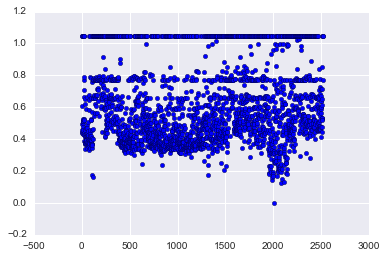

In [48]:
plt.scatter(np.arange(prescriber_dist.shape[0]),prescriber_dist[2010,:])

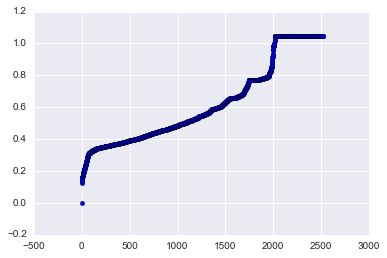

In [49]:
plt.scatter(np.arange(prescriber_dist.shape[0]),np.sort(prescriber_dist[2010,:]))

In [50]:
prescriber_specialty_generic_df.iloc[2010,0:4]

npi                  1487818670
specialty_desc       Psychiatry
total_claim_count           614
drug_count                   18
Name: 1248, dtype: object

In [51]:
providers_sorted = np.lexsort((prescriber_dist[:,2010].tolist(),))

In [52]:
prescriber_specialty_generic_df.iloc[:,0:2].as_matrix()[providers_sorted[0:40],:]

array([[1487818670, u'Psychiatry'],
       [1114970076, u'Psychiatry & Neurology'],
       [1588810162, u'Psychiatry & Neurology'],
       [1265692115, u'Psychiatry'],
       [1366766263, u'Psychiatry & Neurology'],
       [1285815878, u'Psychiatry'],
       [1992965537, u'Certified Clinical Nurse Specialist'],
       [1750616645, u'Psychiatry'],
       [1366618746, u'Psychiatry'],
       [1801919659, u'Certified Clinical Nurse Specialist'],
       [1720241011, u'Neuropsychiatry'],
       [1326086125, u'Psychiatry'],
       [1790964948, u'Psychiatry & Neurology'],
       [1033322730, u'Psychiatry'],
       [1023267606, u'Psychiatry'],
       [1780766881, u'Psychiatry & Neurology'],
       [1316089642, u'Psychiatry'],
       [1164621363, u'Psychiatry & Neurology'],
       [1184876948, u'Psychiatry'],
       [1821259581, u'Psychiatry'],
       [1992746515, u'Psychiatry'],
       [1821073776, u'Psychiatry'],
       [1770868796, u'Nurse Practitioner'],
       [1821025834, u'Psychiatry'],
 

In [53]:
np.lexsort(((-1 * pf_matrix[2010,:]).tolist(),))[0:17]

array([ 72, 214, 590, 715, 515, 331, 613, 151,  48,  96, 297, 537, 415,
       461, 299, 530,   0])

In [54]:
generic_array[np.lexsort(((-1 * pf_matrix[2010,:]).tolist(),))][0:16]

Index([u'BENZTROPINE MESYLATE', u'DIVALPROEX SODIUM', u'QUETIAPINE FUMARATE',
       u'TRAZODONE HCL', u'OLANZAPINE', u'HALOPERIDOL', u'RISPERIDONE',
       u'CLONAZEPAM', u'ARIPIPRAZOLE', u'BUPROPION HCL', u'FLUOXETINE HCL',
       u'PALIPERIDONE PALMITATE', u'LITHIUM CARBONATE', u'MIRTAZAPINE',
       u'FLUPHENAZINE HCL', u'OXCARBAZEPINE'],
      dtype='object')

In [55]:
prescriber_df[prescriber_df["npi"]==1487818670].sort_values("total_claim_count", ascending=False)

,bene_count,bene_count_ge65,bene_count_ge65_redact_flag,description_flag,drug_name,ge65_redact_flag,generic_name,npi,nppes_provider_city,nppes_provider_first_name,nppes_provider_last_org_name,nppes_provider_state,specialty_desc,total_claim_count,total_claim_count_ge65,total_day_supply,total_day_supply_ge65,total_drug_cost,total_drug_cost_ge65,drug_count
27103,28.0,NaN,*,S,BENZTROPINE MESYLATE,*,BENZTROPINE MESYLATE,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,109,NaN,3254,NaN,830.19,NaN,1
29345,20.0,NaN,*,S,DIVALPROEX SODIUM,*,DIVALPROEX SODIUM,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,56,NaN,1664,NaN,1313.52,NaN,1
24981,15.0,NaN,*,S,TRAZODONE HCL,*,TRAZODONE HCL,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,52,NaN,1505,NaN,227.64,NaN,1
7568,12.0,NaN,*,S,OLANZAPINE,*,OLANZAPINE,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,48,NaN,1424,NaN,7963.66,NaN,1
38367,11.0,NaN,*,S,HALOPERIDOL,*,HALOPERIDOL,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,45,NaN,1350,NaN,1544.02,NaN,1
37092,12.0,NaN,*,S,QUETIAPINE FUMARATE,*,QUETIAPINE FUMARATE,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,45,NaN,1350,NaN,3478.24,NaN,1
1665,NaN,0.0,NaN,S,RISPERIDONE,NaN,RISPERIDONE,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,40,0.0,1153,0.0,1138.84,0.0,1
38293,NaN,0.0,NaN,S,CLONAZEPAM,NaN,CLONAZEPAM,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,35,0.0,962,0.0,205.52,0.0,1
27608,NaN,0.0,NaN,S,ABILIFY,NaN,ARIPIPRAZOLE,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,32,0.0,944,0.0,29534.70,0.0,1
11108,NaN,0.0,NaN,S,BUPROPION XL,NaN,BUPROPION HCL,1487818670,WASHINGTON,NAVIN,REDDY,DC,Psychiatry,32,0.0,960,0.0,1196.20,0.0,1


In [56]:
#prescriber_specialty_drugs_df.to_csv("./data/medicare_dc_providers_generic_prescribing_2013.csv")

We take a break from building the algorithm for calculating the euclidean distance between two prescribers. To show how to store the results of your analysis in a format that can be used in other environments. (HDF5)[https://www.hdfgroup.org/HDF5/] is a format for storing scientific data. It can be used by a range of tools include Matlab, Mathematica, R, Python, C and Java. The `h5py` library provides a high level interface for writing and reading HDF5. HDF5 supports compression and reading subsets of really large matrices. 

In [134]:
import h5py

In [135]:
f5 = h5py.File("./data/medicare_dc_prescriber_matrix_2013.hdf5", "w")

In [136]:
ds_raw_count = f5.create_dataset("/generic/raw_counts/core_array/", shape=pf_matrix.shape, dtype=pf_matrix.dtype)
ds_pdist = f5.create_dataset("/prescriber/generic/distance/", shape=prescriber_dist.shape, dtype=prescriber_dist.dtype)
ds_normalized = f5.create_dataset("/generic/normalized/core_array/", shape=normalized_pf_matrix.shape, dtype=normalized_pf_matrix.dtype)
ds_identifiers = f5.create_dataset("/prescriber/identifiers/", shape=identifiers_matrix.shape, dtype="S128")
ds_generic_name = f5.create_dataset("/generic/names", shape=generic_array.shape, dtype="S128")

In [137]:
ds_raw_count[...] = pf_matrix
ds_normalized[...] = normalized_pf_matrix
ds_pdist[...] = prescriber_dist

In [138]:
ds_identifiers[...] = np.array(identifiers_matrix.tolist(), dtype="S128")

In [139]:
ds_generic_name[...] = np.array(generic_array.tolist(), dtype="S128")

In [140]:
f5.close()

Next we will show how the process of creating a data frame for 

In [141]:
np.array(generic_array.tolist(), dtype="S128")[0:20]

array(['0.9 % SODIUM CHLORIDE', 'ABACAVIR SULFATE',
       'ABACAVIR SULFATE/LAMIVUDINE', 'ABACAVIR/LAMIVUDINE/ZIDOVUDINE',
       'ABATACEPT', 'ABIRATERONE ACETATE', 'ACARBOSE',
       'ACETAMINOPHEN WITH CODEINE', 'ACETAZOLAMIDE', 'ACITRETIN',
       'ACLIDINIUM BROMIDE', 'ACYCLOVIR', 'ADALIMUMAB', 'ADAPALENE',
       'ALBUTEROL SULFATE', 'ALCOHOL ANTISEPTIC PADS',
       'ALENDRONATE SODIUM', 'ALENDRONATE SODIUM/VITAMIN D3',
       'ALFUZOSIN HCL', 'ALISKIREN HEMIFUMARATE'], 
      dtype='|S128')

In [142]:
pd.read_json("https://data.medicare.gov/resource/3uxj-hea6?NPI=1487818670")

,adr_ln_1,assgn,cty,frst_nm,gndr,grd_yr,ind_enrl_id,ind_pac_id,ln_2_sprs,lst_nm,med_sch,npi,num_org_mem,org_lgl_nm,org_pac_id,pri_spec,st,zip
0,1221 TAYLOR NWST,Y,WASHINGTON,NAVIN,M,2004,I20130819000117,345410445,N,REDDY,OTHER,1487818670,7,"GREEN DOOR, INC.",1355383308,PSYCHIATRY,DC,200115617


In [143]:
npi_with_distance = pd.DataFrame({"dist": prescriber_dist[2010,:], "npi": prescriber_specialty_generic_df["npi"],  
                                  "specialty_desc": prescriber_specialty_generic_df["specialty_desc"]})

In [144]:
details_df = pd.read_json("https://data.medicare.gov/resource/3uxj-hea6?NPI=1487818670")
for npi in npi_with_distance.sort_values("dist")["npi"][1:50]:
    details_df = details_df.append(pd.read_json("https://data.medicare.gov/resource/3uxj-hea6?NPI=" + str(npi)))

In [145]:
details_df.head(5)

,adr_ln_1,adr_ln_2,assgn,cred,cty,frst_nm,gndr,grd_yr,hosp_afl_1,hosp_afl_2,...,mid_nm,npi,num_org_mem,org_lgl_nm,org_pac_id,pqrs,pri_spec,sec_spec_all,st,zip
0,1221 TAYLOR NWST,NaN,Y,NaN,WASHINGTON,NAVIN,M,2004.0,NaN,NaN,...,NaN,1487818670,7,"GREEN DOOR, INC.",1355383308,NaN,PSYCHIATRY,NaN,DC,200115617
0,9901 MEDICAL CTR DR,NaN,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,T,1265692115,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503357
1,9475 LOTTSFORD RD,NaN,M,NaN,LARGO,SHANIQUE,F,2004.0,210057.0,NaN,...,T,1265692115,9,"QCI BEHAVIORAL HEALTH CONSULTING GROUP, LLC",3971665969,NaN,PSYCHIATRY,NaN,MD,207745346
2,14915 BROSCHART RD,SUITE 2200,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,T,1265692115,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503350
3,14901 BROSCHART RD,NaN,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,T,1265692115,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503318


In [146]:
pd.merge(details_df, npi_with_distance, on="npi")

,adr_ln_1,adr_ln_2,assgn,cred,cty,frst_nm,gndr,grd_yr,hosp_afl_1,hosp_afl_2,...,num_org_mem,org_lgl_nm,org_pac_id,pqrs,pri_spec,sec_spec_all,st,zip,dist,specialty_desc
0,1221 TAYLOR NWST,NaN,Y,NaN,WASHINGTON,NAVIN,M,2004.0,NaN,NaN,...,7,"GREEN DOOR, INC.",1355383308,NaN,PSYCHIATRY,NaN,DC,200115617,0.000000,Psychiatry
1,9901 MEDICAL CTR DR,NaN,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503357,0.143234,Psychiatry
2,9475 LOTTSFORD RD,NaN,M,NaN,LARGO,SHANIQUE,F,2004.0,210057.0,NaN,...,9,"QCI BEHAVIORAL HEALTH CONSULTING GROUP, LLC",3971665969,NaN,PSYCHIATRY,NaN,MD,207745346,0.143234,Psychiatry
3,14915 BROSCHART RD,SUITE 2200,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503350,0.143234,Psychiatry
4,14901 BROSCHART RD,NaN,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503318,0.143234,Psychiatry
5,14915 BROSCHART RD,NaN,M,NaN,ROCKVILLE,SHANIQUE,F,2004.0,210057.0,NaN,...,53,ADVENTIST PHYSICIAN SERVICES INC.,4284631540,NaN,PSYCHIATRY,NaN,MD,208503350,0.143234,Psychiatry
6,9475 LOTTSFORD RD,SUITE 250,M,NaN,LARGO,SHANIQUE,F,2004.0,210057.0,NaN,...,9,"QCI BEHAVIORAL HEALTH CONSULTING GROUP, LLC",3971665969,NaN,PSYCHIATRY,NaN,MD,207745346,0.143234,Psychiatry
7,1338 N CAPITOL NW,SUITE 201 MCCLENDON CENTER,Y,NaN,WASHINGTON,STEVEN,M,1966.0,NaN,NaN,...,4,MCCLENDON CENTER,8224031901,NaN,PSYCHIATRY,NaN,DC,200023396,0.162931,Psychiatry
8,1338 N CAPITOL NW,NaN,Y,NaN,WASHINGTON,STEVEN,M,1966.0,NaN,NaN,...,4,MCCLENDON CENTER,8224031901,NaN,PSYCHIATRY,NaN,DC,200023396,0.162931,Psychiatry
9,1338 N CAPITOL NW,NaN,Y,NaN,WASHINGTON,SARA,F,1983.0,NaN,NaN,...,4,MCCLENDON CENTER,8224031901,NaN,CLINICAL NURSE SPECIALIST,NaN,DC,200023396,0.172722,Certified Clinical Nurse Specialist


In [147]:
#prescriber_specialty_drugs_df.groupby("specialty_desc").agg({"specialty_desc": np.size}).sort_values("specialty_desc", ascending=False)